In [264]:
from collections import defaultdict
import numpy as np

In [265]:
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing', 'flippers'] 
    # this labels is the attribute name label,
    # class label is the last element in each sample point
    return dataSet, labels

In [266]:
def calcShannonEnt(dataSet):
    total_sample = len(dataSet)
    label_cnt = defaultdict(int)
    H = 0 # shannonEnt
    for sample in dataSet:
        label_cnt[sample[-1]] += 1
    for label, cnt in label_cnt.items():
        prob = float(cnt) / total_sample
        H -= prob * np.log2(prob)
#         print(prob)
#     print(total_sample)
#     print(label_cnt)
    return H


In [267]:
dataSet, labels = createDataSet()
calcShannonEnt(dataSet)
# -(np.log2(0.6)*0.6+np.log2(0.4)*0.4)

0.9709505944546686

The higher the entropy, the more mixed up the data is.

In [6]:
dataSet[0][-1] = 'maybe'
calcShannonEnt(dataSet)

1.3709505944546687

Splitting the datset

In [268]:
def splitDatsSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            retDataSet.append(featVec[:axis] + featVec[axis+1:])
    return retDataSet

In [269]:
splitDatsSet(dataSet, 0, 1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

ps:test on set

In [270]:
s = set([1,2,3,2,1,1])
print(s)
2 in s

{1, 2, 3}


True

choosing the best feature to split on

$$ Info(D)=-\sum_{i=1}^{m}p_{i}\log_{2}(p_i) $$

用属性A将D划分为v个子集后，信息度量
$$ Info_{A}(D)=\sum_{j=1}^{v}\frac{\left | D_{j} \right |}{\left | D \right |}\times Info(D_{j}) $$

In [271]:
def chooseBestFeatureToSplit(dataSet):
    baseEntropy = calcShannonEnt(dataSet)
#     print('base entropy ', baseEntropy)
    featVecLen = len(dataSet[0]) - 1
    info_gain = 0
    best_feature_index = -1
    for i in range(featVecLen):
        featureColumn = [d[i] for d in dataSet]
#         print(featureColumn)
        unique_feature = set(featureColumn)
#         print(unique_feature)
        splitEntropy = 0
        for feature in unique_feature:   # for a1,a2,...,av
            subset = splitDatsSet(dataSet, i, feature)
            splitEntropy += float(len(subset))/len(dataSet)*calcShannonEnt(subset)
#         print('split entropy', splitEntropy)
        split_info_gain = baseEntropy - splitEntropy
#         print(split_info_gain)
        if split_info_gain > info_gain:
            info_gain = split_info_gain
            best_feature_index = i
    return best_feature_index, info_gain

In [272]:
chooseBestFeatureToSplit(dataSet)

(0, 0.4199730940219749)

### majority vote function

In [273]:
def majority_vote(class_list):
    class_cnt = defaultdict(int)
    for c in class_list:
        class_cnt[c] += 1
    vote = sorted(class_cnt.items(), key=lambda p:p[1], reverse=True)
#     print(vote)
    return vote[0][0]

In [274]:
d = [1,2,2,5,1,1]
majority_vote(d)

1

### recursively build the tree 

In [275]:
# test
dataset =[['tall','classA'],['tall','classB']]
dataset =[['tall','classA'],['tall','classA']]
print(calcShannonEnt(dataset))
abs(calcShannonEnt(dataset) - 0) < 1e-6

0.0


True

#### my version 

In [364]:
class BaseNode:
    def __init__(self, child):
        self.child = child
    def add_child(self, value, node):
        self.child[value] = node
    def __iter__(self):
        return iter(self.child)
    def depth_first(self):
        yield 'decision node split axis: {}'.format(self.feature_axis)
        for c_value, c_node in self.child.items():
            yield from c_node.depth_first()
        
class LeafNode(BaseNode):
    def __init__(self, class_label):
        super().__init__(None) 
        self.class_label = class_label
    def depth_first(self):
        yield 'leaf node class: {}'.format(self.class_label)
    
class DecisionNode(BaseNode):
    def __init__(self, feature_axis, child):
        super().__init__(child)
        print('node info', id(self), id(self.child))
        self.feature_axis = feature_axis
    

In [365]:

def build_decision_tree(dataset, d):
#     if d >= 2: return None
    print(dataset)
    features_num = len(dataset[0]) - 1
    # run out of features or all sample in node's dataset belong to the same class
 
    if features_num == 0 or abs(calcShannonEnt(dataset) - 0) < 1e-6:  # add leaf node
        voted_class = majority_vote([sample[-1] for sample in dataset])
#         print(voted_class)
        node = LeafNode(voted_class)
        print(4*d*' ' + 'ln node id', id(node))
#         print('ln node', id(node))
        return node
#         parent_node.add_child(LeafNode(voted_class))
    else: # add decison node
        split_feature_axis, _ = chooseBestFeatureToSplit(dataset)
        unique_feature_set = set([sample[split_feature_axis] for sample in dataset])
        cur_node = DecisionNode(split_feature_axis, child={})
        print(4*d*' ' + 'dc node', id(cur_node))
#         print(unique_feature_set)
        for i, value in enumerate(unique_feature_set):
            subset = splitDatsSet(dataset, split_feature_axis, value) 
            child_node = build_decision_tree(subset, d+1)
            print(4*d*' ' + 'parent {}, {} {} child id {} {}'.format(id(cur_node), i,value, id(child_node), subset))
#             cur_node.child[value] = child_node
            cur_node.add_child(value, child_node)
            print(4*d*' ' + '{}'.format(id(cur_node.child[value])))
        return cur_node

In [366]:
# print(dataSet)
# root = DecisionNode(dataSet, None, None, None)

root = build_decision_tree(dataSet, d=0)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
node info 4405652448 4405504472
dc node 4405652448
[[1, 'no'], [1, 'no']]
    ln node id 4405671136
parent 4405652448, 0 0 child id 4405671136 [[1, 'no'], [1, 'no']]
4405671136
[[1, 'yes'], [1, 'yes'], [0, 'no']]
node info 4405671472 4405511296
    dc node 4405671472
[['no']]
        ln node id 4405670408
    parent 4405671472, 0 0 child id 4405670408 [['no']]
    4405670408
[['yes'], ['yes']]
        ln node id 4405651552
    parent 4405671472, 1 1 child id 4405651552 [['yes'], ['yes']]
    4405651552
parent 4405652448, 1 1 child id 4405671472 [[1, 'yes'], [1, 'yes'], [0, 'no']]
4405671472


In [367]:


print(id(root))
# print(id(root.child)
print(root.child, id(root.child[0]), id(root.child[1]))
print(id(root.child[1]))
# print(id(root.child[1].child[0]))
# print(root.child[1].child)



4405652448
{0: <__main__.LeafNode object at 0x1069934e0>, 1: <__main__.DecisionNode object at 0x106993630>} 4405671136 4405671472
4405671472


In [368]:
print(root)
print(root.child)
print(root.child[1].child)

{0: <__main__.LeafNode object at 0x1069934e0>, 1: <__main__.DecisionNode object at 0x106993630>}
{0: <__main__.LeafNode object at 0x106993208>, 1: <__main__.LeafNode object at 0x10698e860>}


#### 发现一个很严重，很需要注意的问题，构造函数中的默认参数在实例之间共享 ；不建议用[], {} 等对象做默认实参，尤其是后续会修改的话

In [369]:
class D:
    def __init__(self, d = {}):
        self.d = d
        print('info: ', id(self), id(self.d))

d1 = D()
d2 = D()
# 两个id 一样

info:  4405650544 4406203160
info:  4405650432 4406203160


In [370]:
class D:
    def __init__(self, d):
        self.d = d
        print('info: ', id(self), id(self.d))

d1 = D({})
d2 = D({})
# 这样两个id就不一样

info:  4405693632 4405607520
info:  4405690552 4406261944


### 遍历decision tree 

In [371]:
for n in root.depth_first():
    print(n)

decision node split axis: 0
leaf node class: no
decision node split axis: 0
leaf node class: no
leaf node class: yes


### code in book 

In [396]:
def createTree(dataset, labels):
    labels = labels[:]
    class_list = [sample[-1] for sample in dataset]
    if class_list.count(class_list[0]) == len(class_list):
        return class_list[0]
    if len(dataset[0]) == 1:
        return majority_vote(class_list)
    best_feat, _ = chooseBestFeatureToSplit(dataset)
    best_feat_label = labels[best_feat]
#     print(best_feat, best_feat_label)
    myTree = {best_feat_label: {}}
    del(labels[best_feat])
    feat_values = [sample[best_feat] for sample in dataset]
    unique_vals = set(feat_values)
    for feat in unique_vals:
        sub_dataset = splitDatsSet(dataset, best_feat, feat)
        myTree[best_feat_label][feat] = createTree(sub_dataset, labels)
    return myTree

In [397]:
dataset, labels = createDataSet()
myTree = createTree(dataset, labels[:])
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [398]:
print(labels)

['no surfacing', 'flippers']


### plotting tree nodes 

In [402]:
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,xycoords='axes fraction',
    xytext=centerPt, textcoords='axes fraction',
    va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)
    
def createPlot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon=False)
    plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode('a leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()

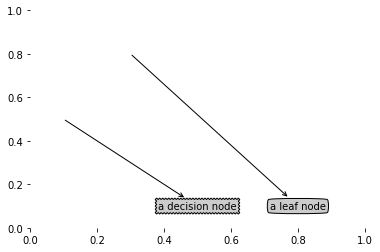

In [403]:
createPlot()

In [439]:
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
#     _, secondDict = next(iter(myTree.items()))
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
#     _, secondDict = next(iter(myTree.items()))
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

In [440]:
print(myTree)
getTreeDepth(myTree)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


2

In [441]:
getNumLeafs(myTree)

3

In [442]:
def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': \
                    {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': \
                    {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

In [444]:
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)
    
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff),
                cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
    
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0; plotTree(inTree, (0.5,1.0), '')
    plt.show()

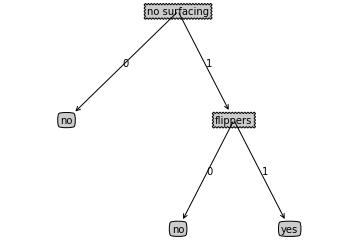

In [445]:
myTree=retrieveTree(0)
createPlot(myTree)

### Lenses decision tree 

In [452]:
from pprint import pprint
with open('lenses.txt', 'r') as f:
#     for line in f:
#         print(line.strip().split('\t'))
    lenses_dataset = [line.strip().split('\t') for line in f.readlines()]
lenses_labels = ['age', 'prescript', 'astigmatic', 'tearRate']

pprint(lenses_dataset)
print(lenses_labels)

[['young', 'myope', 'no', 'reduced', 'no lenses'],
 ['young', 'myope', 'no', 'normal', 'soft'],
 ['young', 'myope', 'yes', 'reduced', 'no lenses'],
 ['young', 'myope', 'yes', 'normal', 'hard'],
 ['young', 'hyper', 'no', 'reduced', 'no lenses'],
 ['young', 'hyper', 'no', 'normal', 'soft'],
 ['young', 'hyper', 'yes', 'reduced', 'no lenses'],
 ['young', 'hyper', 'yes', 'normal', 'hard'],
 ['pre', 'myope', 'no', 'reduced', 'no lenses'],
 ['pre', 'myope', 'no', 'normal', 'soft'],
 ['pre', 'myope', 'yes', 'reduced', 'no lenses'],
 ['pre', 'myope', 'yes', 'normal', 'hard'],
 ['pre', 'hyper', 'no', 'reduced', 'no lenses'],
 ['pre', 'hyper', 'no', 'normal', 'soft'],
 ['pre', 'hyper', 'yes', 'reduced', 'no lenses'],
 ['pre', 'hyper', 'yes', 'normal', 'no lenses'],
 ['presbyopic', 'myope', 'no', 'reduced', 'no lenses'],
 ['presbyopic', 'myope', 'no', 'normal', 'no lenses'],
 ['presbyopic', 'myope', 'yes', 'reduced', 'no lenses'],
 ['presbyopic', 'myope', 'yes', 'normal', 'hard'],
 ['presbyopic', 

In [455]:
lenses_tree = createTree(lenses_dataset, lenses_labels)
pprint(lenses_tree)

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
                                                       'presbyopic': {'prescript': {'hyper': 'soft',
                                                                                    'myope': 'no '
                                                                                             'lenses'}},
                                                       'young': 'soft'}},
                                        'yes': {'prescript': {'hyper': {'age': {'pre': 'no '
                                                                                       'lenses',
                                                                                'presbyopic': 'no '
                                                                                              'lenses',
                                                                                'young': 'hard'}},
                                                          

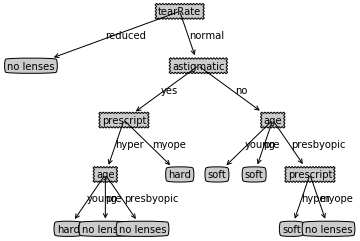

In [456]:
createPlot(lenses_tree)